In [1]:
import pandas as pd
import numpy as np
import h5py
from scipy.special import logsumexp
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import chart_studio.plotly as py
import plotly.graph_objects as go

import igraph

In [3]:
with h5py.File('/net/seq/data2/projects/sabramov/SuperIndex/dnase-0209/output/normalized_matrices.hdf5', 'r') as f:
    sample_ids = f['samples'][:].astype(str)

In [4]:
emb_meta = pd.read_table('/net/seq/data2/projects/ENCODE4Plus/indexes/index_altius_23-05-11/metadata/ENCODE4plus_master_metadata_for_analysis.tsv')
# emb_meta = emb_meta.set_index('id').loc[sample_ids]
emb_meta = emb_meta.set_index('id')
emb_meta['log_align'] = np.log10(emb_meta['autosomal_align'])
emb_meta

,tc_number,ds_number,ln_number,passed_agg_qc,hotspot1_spot,hotspot2_spot,nuclear_percent_duplication,taxonomy_name,ontology_id,ontology_term,...,dedupped_subsampled_spot1,dupRate_5M,library_kit,ln,nuclear_aligned,total_aligned,alignment_quality,dhsCounts_AllSamplesIndex,read_depth,log_align
id,,,,,,,,,,,,,,,,,,,,,
AG80700,6976,DS14320,LN3035,YES,0.5805,0.4312,19.1227,h.WI-38,EFO:0001260,WI38,...,0.4664,0.084913,PE,LN3035,21539393.0,35421258.0,0.608092,62051.0,21516913.0,7.320983
AG80701,6977,DS14315,LN3034,YES,0.6998,0.5295,23.9026,h.WI-38,EFO:0001260,WI38,...,0.5765,0.111073,PE,LN3034,20727548.0,34235166.0,0.605446,68843.0,20534118.0,7.305907
AG80698,6974,DS14328,LN3037,YES,0.4922,0.2903,12.4819,h.WI-38,EFO:0001260,WI38,...,0.3903,0.045887,PE,LN3037,24003639.0,34127036.0,0.703361,50237.0,23976239.0,7.366547
AG80699,6975,DS14323,LN3036,YES,0.6416,0.4020,18.2760,h.WI-38,EFO:0001260,WI38,...,0.5361,0.067307,PE,LN3036,24984098.0,34253236.0,0.729394,60925.0,24965490.0,7.387349
AG80796,6419,DS12393,LN2503,YES,0.5689,0.4299,21.6078,CMK,EFO:0003037,CMK,...,0.4431,0.078924,PE,LN2503,32730192.0,60738773.0,0.538868,68501.0,32693071.0,7.503502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AG6932,7522,DS39309,LN42982C,NO,0.2566,0.1794,13.7181,h.smooth muscle cell,CL:0000192,smooth muscle cell,...,0.2496,0.007212,Thruplex DNA-Seq H,LN42982C,219501818.0,264602842.0,0.829552,107648.0,193679177.0,8.326304
AG6933,7523,DS39312,LN42983C,NO,0.2594,0.1888,12.8734,h.smooth muscle cell,CL:0000192,smooth muscle cell,...,0.2524,0.005988,Thruplex DNA-Seq H,LN42983C,242141104.0,293510790.0,0.824982,134383.0,210615155.0,8.369217
AG6944,2400,DS55923,LN43606A,YES,0.4793,0.5028,42.7986,h.DE,CL:0000223,endodermal cell,...,0.4638,0.014498,Thruplex DNA-Seq Q,LN43606A,458528756.0,569316312.0,0.805402,301804.0,455107921.0,8.649232


In [5]:
## saved version

# import pandas as pd

# def assign_category_if_enough_samples(row, df, columns_list, cat_column, tr):
#     if pd.isna(row[cat_column]):
#         return ['NA']
#     vc = df[
#         df.eval(' & '.join([f'{col} == "{row[col]}"' for col in columns_list]))
#     ][cat_column].value_counts()
#     if vc[row[cat_column]] >= tr:
#         return [row[cat_column]]
#     else:
#         return ['Other']

# def get_cluster(row, df, tr):
#     ret = [row['disease_pathology'], row['sampling_origin']]
#     if row['disease_pathology'] == 'Normal':
#         if row['sampling_origin'] == 'Cultured':
#             if row['state'] == 'Cell line':
#                 ret += ['CellLine'] + assign_category_if_enough_samples(
#                     row, df,
#                     columns_list=['disease_pathology',
#                                     'sampling_origin',
#                                     'state'],
#                     cat_column='cell_type',
#                     tr=tr
#                 )
#             else:
#                 ret += ['StemAndPrimary']
#         elif row['sampling_origin'] == 'Tissue':
#             if pd.isna(row['growth_stage']):
#                 ret += ['NA']
#             else:
#                 if row['growth_stage'] == 'Postnatal':
#                     ret += ['Postnatal']
#                 else:
#                     ret += ['Fetal']

#                 assert not pd.isna(row['system'])
#                 ret += [row["system"]]
                
#                 ret += assign_category_if_enough_samples(
#                     row, df,
#                     columns_list=['disease_pathology',
#                                     'sampling_origin',
#                                     'growth_stage',
#                                     'system'],
#                     cat_column='organ',
#                     tr=tr
#                 )

#                 # Further splitting up two biggest organs
#                 if row['growth_stage'] == 'Postnatal':
#                     if row['organ'] == 'Blood':
#                         assert not pd.isna(row['subsystem'])
#                         assert not pd.isna(row['cell_type'])
#                         ret += [row["subsystem"], row["cell_type"]]
#                     elif row['organ'] == 'Brain':
#                         ret += assign_category_if_enough_samples(
#                             row, df,
#                             columns_list=['disease_pathology',
#                                             'sampling_origin',
#                                             'growth_stage',
#                                             'organ'],
#                             cat_column='organ_region',
#                             tr=tr
#                         )
#     elif row['disease_pathology'] == 'Cancer':
#         assert not pd.isna(row['system'])
#         ret += [row['system']] + assign_category_if_enough_samples(
#             row, df,
#             columns_list=['disease_pathology',
#                             'sampling_origin',
#                             'system'],
#             cat_column='cell_type',
#             tr=tr
#         )
#     else:
#         print(row['disease_pathology'])
#         print(row)
#         raise ValueError
    
#     return '@'.join(ret)

# def get_ontology_term(row, df, tr):
#     ret = row['annotation_ontology'].split('@')
#     if ret[-1] not in ['Other', 'NA']:
#         ret += assign_category_if_enough_samples(
#             row, df,
#             columns_list=['annotation_ontology'],
#             cat_column='ontology_term',
#             tr=tr
#         )
#     return '@'.join(ret)


# def add_annotation_ontology(df, tr=15):
#     # Temporary workaround for AG72376 AG72354 AG72351 AG72349
#     df.loc[df['subsystem'] == 'B-cell', 'subsystem'] = 'Lymphoid'

#     # Temporary workaround for AG7206
#     df.loc['AG7206', ['disease_pathology', 'sampling_origin', 'system', 'cell_type']] =\
#         pd.Series(['Cancer', 'Cultured', 'Hematopoietic', 'Lymphoblast'],
#                   index=['disease_pathology', 'sampling_origin', 'system', 'cell_type'])
    
#     df['annotation_ontology'] = df.progress_apply(lambda row: get_cluster(row, df, tr), axis=1)
#     df['annotation_ontology'] = df.progress_apply(lambda row: get_ontology_term(row, df, tr), axis=1)

#     return df

In [6]:
# df = add_annotation_ontology(emb_meta, tr=1)
# df['annotation_ontology'] = df['annotation_ontology'].str.replace('NA', "Other")

In [7]:
df = emb_meta.copy()
df.columns

Index(['tc_number', 'ds_number', 'ln_number', 'passed_agg_qc', 'hotspot1_spot',
       'hotspot2_spot', 'nuclear_percent_duplication', 'taxonomy_name',
       'ontology_id', 'ontology_term', 'disease_pathology', 'sampling_origin',
       'state', 'growth_stage', 'system', 'subsystem', 'organ', 'organ_region',
       'cell_type', 'immune_cells_subtype', 't_cells_subpopulation',
       'cell_markers', 'side_position', 'germ_layer', 'description',
       'donor_id', 'donor_age', 'donor_age_units', 'donor_sex',
       'donor_ethnicity', 'donor_health_condition', 'vendor_name',
       'perturbation', 'treatment_name', 'treatment_details', 'dose',
       'dose_units', 'filtered_alignments_bam', 'bam_index', 'hotspot_peaks',
       'hotspot_peaks_1per', 'hotspot_peaks_point1per', 'footprint', 'adapter',
       'total_alignments', 'all_aligned', 'all_mapq_filter', 'autosomal_align',
       'chr_m', 'hotspot1_num_bases', 'hotspot1_num_spots',
       'hotspot2_num_bases', 'hotspot2_num_spots', '

In [8]:
df[df['ontology_term'] == 'K562'][['sampling_origin', 'disease_pathology', 'state', 'cell_type']]

,sampling_origin,disease_pathology,state,cell_type
id,,,,
AG80850,Cultured,Cancer,Cell line,Lymphoblast
AG80851,Cultured,Cancer,Cell line,Lymphoblast
AG80615,Cultured,Cancer,Cell line,Lymphoblast
AG80660,Cultured,Cancer,Cell line,Lymphoblast
AG10628,Cultured,Cancer,Cell line,Lymphoblast
...,...,...,...,...
AG82621,Cultured,Cancer,Cell line,Lymphoblast
AG82619,Cultured,Cancer,Cell line,Lymphoblast
AG82618,Cultured,Cancer,Cell line,Lymphoblast


In [9]:
# Hotfixes
df.loc[df['ontology_term'] == 'L1-S8', 'cell_type'] = 'Progenitor'
df.loc[df['ontology_term'] == 'GM23338', 'state'] = 'Stem cells'
df.loc[df.eval('disease_pathology == "Normal" & sampling_origin == "Tissue" & state == "Cell line"'), 'sampling_origin'] = 'Cultured'
ids = df.loc[df.eval('disease_pathology == "Normal" & sampling_origin == "Tissue" & growth_stage == "Embryonic"'), :].index
df.loc[ids, 'sampling_origin'] = 'Cultured'
df.loc[ids, 'state'] = 'Stem cells'
df.loc[df.eval('disease_pathology == "Normal" & sampling_origin == "Tissue"') & pd.isna(df['growth_stage']), 'growth_stage'] = 'Postnatal'
df.loc[df.eval('disease_pathology == "Normal" & sampling_origin == "Tissue" & growth_stage == "Neonatal"'), 'growth_stage'] = 'Postnatal'
df.loc[df['ds_number'] == 'DS55951', 'sampling_origin'] = 'Cultured'
df.loc[df['ds_number'] == 'DS52908', 'sampling_origin'] = 'Cultured'
df.loc[df['ds_number'] == 'DS52908', 'disease_pathology'] = 'Cancer'
df.loc[df['ds_number'] == 'DS52908', 'state'] = 'Cell line'
df.loc[df['ds_number'] == 'DS52908', 'cell_type'] = 'Lymphoblast'
df.loc[df.eval('disease_pathology == "Normal" & sampling_origin == "Cultured" & state == "Primary"')
       & df['description'].str.contains('differentiated'), 'state'] = 'Differentiated stem cells'

In [69]:
# ontology_configuration = {
#     '0': ['Root', 'Root', None],
#     '1': ['Sampling origin', 'sampling_origin', None],
#     '2': ['Disease pathology', 'disease_pathology', None],
#     '3': ['Growth stage', 'growth_stage', 'sampling_origin == "Tissue" & disease_pathology == "Normal"'],
#     '4.1': ['System', 'system', 'sampling_origin != "Cultured" | disease_pathology != "Normal"'],
#     '4.2': ['State', 'state', 'sampling_origin == "Cultured" & disease_pathology == "Normal"'],
#     '5.1': ['Cell type', 'cell_type', 'sampling_origin == "Cultured"'],
#     '5.2': ['Organ', 'organ', 'sampling_origin == "Tissue"'],
#     '6.1': ['Organ region', 'organ_region', 'sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & organ == "Brain"'],
#     '6.2': ['Subsystem', 'subsystem', 'sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & organ == "Blood"'],
#     '7': ['Blood cell type', 'cell_type', 'sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & organ == "Blood"'],
#     '8': ['Ontology term', 'ontology_term', None],
# }

ontology_configuration = [
    {
      'level': 0,
      'display_name': 'Root',
      'column_name': 'Root',
      'condition': None,
    },
    {
      'level': 1,
      'display_name': 'Sampling origin',
      'column_name': 'sampling_origin',
      'condition': None,
    },
    {
      'level': 2,
      'display_name': 'Disease pathology',
      'column_name': 'disease_pathology',
      'condition': None,
    },
    {
      'level': 3,
      'display_name': 'State',
      'column_name': 'state',
      'condition': 'sampling_origin == "Cultured"',# & disease_pathology == "Normal"',
    },
    {
      'level': 3,
      'display_name': 'Growth stage',
      'column_name': 'growth_stage',
      'condition': 'sampling_origin == "Tissue" & disease_pathology == "Normal"',
    },
    {
      'level': 4,
      'display_name': 'System',
      'column_name': 'system',
      'condition': 'sampling_origin != "Cultured" | disease_pathology != "Normal" | state == "Primary"',
    },
    {
      'level': 5,
      'display_name': 'Subsystem',
      'column_name': 'subsystem',
      'condition': 'sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & (system == "Hematopoietic" | system == "Nervous")',
    },
    {
      'level': 6,
      'display_name': 'Organ',
      'column_name': 'organ',
      'condition': 'sampling_origin == "Tissue" | (sampling_origin == "Cultured" & disease_pathology == "Normal" & state == "Primary")',
    },
#     {
#       'level': 8,
#       'display_name': 'Organ region',
#       'column_name': 'organ_region',
#       'condition': 'sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & organ == "Brain"',
#     },
    {
      'level': 7,
      'display_name': 'Cell type',
      'column_name': 'cell_type',
      'condition': '(sampling_origin == "Cultured" & state != "Primary" & state != "Stem cells") | (sampling_origin == "Tissue" & disease_pathology == "Normal" & growth_stage == "Postnatal" & organ == "Blood")',
    },
    {
      'level': 8,
      'display_name': 'Ontology term',
      'column_name': 'ontology_term',
      'condition': None,
    },
]

def join_row(row, oc, skip_na):
    res = ''
    for ind in row.index:
        if row[ind] != 'NA' or not skip_na:
            entry = [x for x in oc if x['display_name'] == ind][0]
            res += f"{entry['display_name']}: {row[ind]}|{entry['level']}@"
    return res[:-1]

def add_ontology(df, ontology_configuration, skip_na=True):
    work = df.copy()
    for entry in ontology_configuration:
        if entry['column_name'] in work.columns:
            column_name = work[entry['column_name']]
        else:
            column_name = entry['column_name']
        work[entry['display_name']] = 'NA'
        work.loc[slice(None) if entry['condition'] is None else work.eval(entry['condition']), entry['display_name']] = column_name
    work.fillna('MISSING', inplace=True)
    df['annotation_ontology'] = work.loc[:, [x['display_name'] for x in ontology_configuration]].apply(
        lambda row: join_row(row, ontology_configuration, skip_na), axis=1)
        

In [70]:
def accumulate_tokens(lis):
    total = None
    for x in lis:
        total = f'{total}@{x}' if total is not None else x
        yield total

def get_graph_params(evc):
    edges = []
    labels = []
    values = []
    count = []
    layers = []
    for ont, cnt in evc.items():
        tokens = ont.split('@')
        tokens = list(accumulate_tokens(tokens))
        for i, token in enumerate(tokens):
            if token in labels:
                v = labels.index(token)
            else:
                labels.append(token)
                values.append(0)
                count.append(0)
                layers.append(int(token.split('|')[-1]))
                v = len(labels) - 1
            if i > 0:
                edge = [labels.index(tokens[i - 1]), v]
                if edge not in edges:
                    edges.append(edge)
            values[v] += cnt
            count[v] += 1
    
    transform_label = lambda x: '@'.join([z for z in map(lambda y: y.split("|")[0], x.split('@')) if 'NA' not in z])
    transformed_labels = [transform_label(x) for x in labels]
    labels = [f'{label.split("@")[-1].split("|")[0]} ({value})' for label, value in zip(labels, values)]

    return edges, labels, transformed_labels, values, count, layers

In [71]:
import igraph
from igraph import Graph, EdgeSeq

add_ontology(df, ontology_configuration)
evc = df['annotation_ontology'].value_counts().sort_index()

edges, labels, transformed_labels, values, count, layers = get_graph_params(evc)
nr_vertices = len(labels)
g = Graph(len(labels), edges=edges)

E = edges
M = max(layers)

In [112]:
from collections import deque

def gap(level, M):
    return {
        1: 0.5,
        2: 4,
        3: 4,
        4: 4,
        5: 4,
        6: 10,
        7: 20,
        8: 20,
    }[M - level]

class QueueDict():
    def __init__(self, root, M):
        self.q = {}
        for i in range(M + 1):
            if i == 0:
                self.q[i] = deque([root])
            else:
                self.q[i] = deque([])

                
    def append(self, v, layer):
        self.q[layer].append(v)
        
    def pop(self):
        for dq in self.q.values():
            if dq:
                return dq.pop()
    
    def __bool__(self):
        return any(x for x in self.q.values())

    
def level_search(g, layers, root, M, q=None, res=None):
    if q is None:
        q = QueueDict(root, M)
        res = []

    while q:
        v = q.pop()
        res.append(v)
        for n in g.neighbors(v):
            if layers[v] < layers[n]:
                q.append(n, layers[n])
                level_search(g, layers, n, M, q, res)
            
    return res


v_order = level_search(g, layers, 0, M)
print(len(v_order))
ordered_layers = [layers[v] for v in v_order]
ordered_leaves = [v for v, l in zip(v_order, ordered_layers) if l == M]
print(len(ordered_leaves))
v_widths = {}
Xpos = {}
prev = None
current_x = 0
for v in ordered_leaves:
    if prev is not None:
        current_x += gap(min([
            layers[x] for x in g.get_shortest_paths(prev, v)[0]
        ]), M)
    prev = v
    Xpos[v] = current_x
for l in range(M)[::-1]:
    for v in v_order:
        if layers[v] == l:
            children = [Xpos[x] for x in g.neighbors(v) if layers[x] > layers[v]]
            Xpos[v] = np.mean(children)
            v_widths[v] = np.max(children) - np.min(children)
Xn = [Xpos[v] for v in range(nr_vertices)]
Yn  = [M - layers[k] for k in range(len(Xn))]
# Xe = []
# Ye = []
# for edge in E:
#     Xe+=[Xn[edge[0]],Xn[edge[1]], None]
#     Ye+=[Yn[edge[0]],Yn[edge[1]], None]
splines = []
widths = []
a1 = 0.5
a2 = 0.5
for edge in E:
    splines += [[Xn[edge[0]], Yn[edge[0]],
                 Xn[edge[0]], Yn[edge[0]] + a1*(Yn[edge[1]] - Yn[edge[0]]),
                 Xn[edge[1]], Yn[edge[1]] + a2*(Yn[edge[0]] - Yn[edge[1]]), 
                 Xn[edge[1]], Yn[edge[1]]]]
    widths.append(values[edge[1]])
    
max_y = max(Yn)
min_y = min(Yn)
max_x = max(Xn)
min_x = min(Xn)
# def convert_from_polar(x, y, min_x, max_x, min_y, max_y):
#     phi = 2 * np.pi * (x - min_x) / (max_x - min_x)
#     r = 1 - (y - min_y) / (max_y - min_y)
#     return r * np.sin(phi), r * np.cos(phi)

# def transform_spline(s, min_x, max_x, min_y, max_y):
#     pairs = [s[i:i+2] for i in range(0, len(s), 2)]
#     ret = [convert_from_polar(a, b, min_x, max_x, min_y, max_y) for a, b in pairs]
#     return [b for a in ret for b in a]

# Xn, Yn = zip(*[convert_from_polar(a, b, min_x, max_x, min_y, max_y) for a, b in zip(Xn, Yn)])
# splines = [transform_spline(s, min_x, max_x, min_y, max_y) for s in splines]

593
390


In [113]:
"M {0},{1} C {2},{3} {4},{5} {6},{7}".format(*splines[0])

'M 358.44111009700754,8 C 358.44111009700754,7.5 166.2930935778237,7.5 166.2930935778237,7'

In [114]:
colors = ['#DB4551' if 'MISSING' in label else '#6175c1' for label in labels]
fun = lambda x: np.log2(1+x)#*np.power(x, 1/6)
sizes = [fun(x) for x in values]
fwidths = [0.5*fun(x) for x in widths]

In [145]:
nodes_to_annotate = [v for v in v_order if 0 < layers[v] <= 3]

In [154]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
# fig.add_trace(go.Scatter(x=Xe,
#                    y=Ye,
#                    mode='lines',
#                    line=dict(color='rgb(210,210,210)', width=1),
#                    hoverinfo='none'
#                    ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  marker=dict(symbol='circle',
                                size=sizes,
                                color=colors,
                                line=dict(color='rgb(50,50,50)', width=0.5),
                                opacity=1,
                                sizemode='diameter',
                                ),
                  text=labels,
                  hoverinfo='text',
                  ))
axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )
fig.update_layout(title= '3780 Metadata',
#               annotations=make_annotations(position, v_label),
              font_size=12,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
#               plot_bgcolor='rgb(248,248,248)',
              plot_bgcolor='rgb(255,255,255)',
              shapes=[
                dict(
                  type="path",
                  path="M {0},{1} C {2},{3} {4},{5} {6},{7}".format(*s),
                  line=dict(
#                       color='rgb(120,120,120)',
                      color='rgb(180,180,180)',
                      width=w,
                  ),
                  layer="below",
                )
                for s, w in zip(splines, fwidths)
              ]
              )
line_labels = {}
for oc in ontology_configuration[::-1]:
    line_labels.setdefault(oc['level'], []).append(oc['display_name'])
line_labels = ['/'.join(x) for x in line_labels.values()]

for i, oc in zip(range(M), line_labels):
    fig.add_hline(y=min_y + i, line_width=0.5, line_dash='dash', line_color='rgb(200,200,200)',
              annotation_text=oc, 
              annotation_position="top left",
              annotation_font_size=15,
              annotation_font_color="rgb(50,50,50)")
for v in nodes_to_annotate:
    fig.add_annotation(
        x=Xn[v], y=Yn[v],
        text=labels[v].split(': ')[1].split(' (')[0].replace(
            'Differentiated stem cells', 'Differentiated\nstem cells'),
        showarrow=False,
        xanchor="center",
        yanchor="bottom",
        yshift=5,
        font=dict(
            color="rgb(50,50,50)",
            size=8,
        )
    )
delta = max_x - min_x
fig.update_xaxes(range=[min_x - 0.15 * delta, max_x + 0.01 * delta])
fig.show()
fig.write_html("/home/sboytsov/meta_figures/meta_hierarchy_backup.html")

In [116]:
def make_annotations(pos, text, font_size=10, font_color='rgb(250,250,250)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text=labels[k], # or replace labels with a different list for the text within the circle
                x=pos[k][0], y=2*M-position[k][1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    return annotations

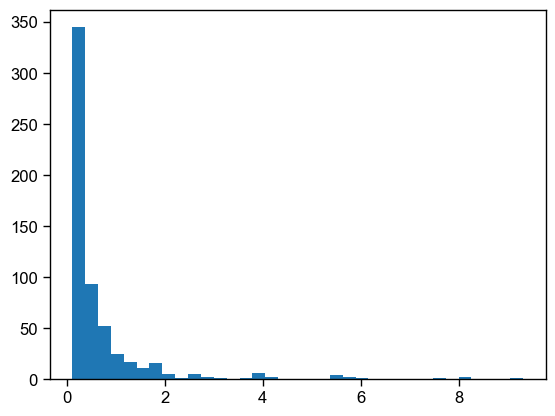

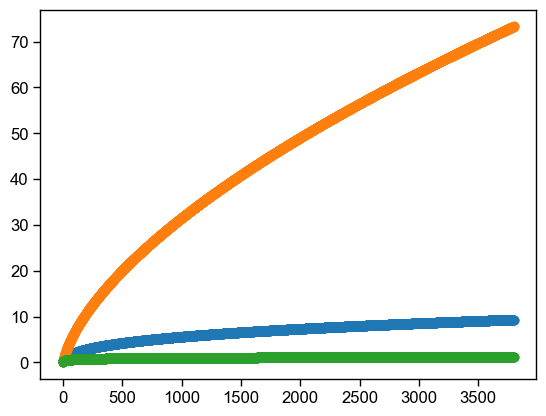

In [117]:
from matplotlib import pyplot as plt
plt.hist([0.1*np.log2(1+x)*np.power(x, 1/4) for x in values])
plt.show()
X = np.linspace(0, 3800, 3801)
y1 = [0.1*np.log2(1+x)*np.power(x, 1/4) for x in X]
y2 = [0.1*np.log2(1+x)*np.power(x, 1/2) for x in X]
y3 = [0.1*np.log2(1+x) for x in X]
plt.scatter(X, y1)
plt.scatter(X, y2)
plt.scatter(X, y3)